In [129]:
!pip install snowflake-connector-python sqlalchemy snowflake-connector-python[pandas] snowflake.sqlalchemy numpy;

  Using cached snowflake_sqlalchemy-1.2.4-py2.py3-none-any.whl (29 kB)


In [69]:
%matplotlib inline

In [130]:
import snowflake.sqlalchemy;
import pandas as pd;
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine;
from sqlalchemy.dialects import registry
import matplotlib.pyplot as plt
import numpy as np

In [151]:
registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')

engine = create_engine(URL(
    account = 'propertyfinder.eu-west-1',
    user = 'PSTRUGACZ',
    password = 't$3TN[66{s',
    database = 'PFDW_DEV_COMMON_DB',
    warehouse = 'PFDW_REMOVE_DUPLICATE_SNOWPLOW_CONTEXTS',
    role='SYSADMIN',
))

In [100]:
download_url = ("https://raw.githubusercontent.com/fivethirtyeight/"
                "data/master/college-majors/recent-grads.csv")

df = pd.read_csv(download_url)
df.head()

# r, c = df.shape
# print(r, c)

# df.plot(x="Rank", y=["P25th", "Median", "P75th"])

# median_column = df["Median"]
# median_column.plot(kind="hist")


,Rank,Major_code,Major,Total,Men,Women,Major_category,ShareWomen,Sample_size,Employed,Full_time,Part_time,Full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th,College_jobs,Non_college_jobs,Low_wage_jobs
0,1,2419,PETROLEUM ENGINEERING,2339.0,2057.0,282.0,Engineering,0.120564,36,1976,1849,270,1207,37,0.018381,110000,95000,125000,1534,364,193
1,2,2416,MINING AND MINERAL ENGINEERING,756.0,679.0,77.0,Engineering,0.101852,7,640,556,170,388,85,0.117241,75000,55000,90000,350,257,50
2,3,2415,METALLURGICAL ENGINEERING,856.0,725.0,131.0,Engineering,0.153037,3,648,558,133,340,16,0.024096,73000,50000,105000,456,176,0
3,4,2417,NAVAL ARCHITECTURE AND MARINE ENGINEERING,1258.0,1123.0,135.0,Engineering,0.107313,16,758,1069,150,692,40,0.050125,70000,43000,80000,529,102,0
4,5,2405,CHEMICAL ENGINEERING,32260.0,21239.0,11021.0,Engineering,0.341631,289,25694,23170,5180,16697,1672,0.061098,65000,50000,75000,18314,4440,972


In [ ]:
connection = engine.connect()
# connection.execute(
#     "CREATE OR REPLACE TABLE ts_tbl(c1 TIMESTAMP_NTZ)")
# connection.execute(
#     "INSERT INTO ts_tbl(c1) values(%s)", (specific_date,)
# )

pd.set_option("display.max.columns", None)

query = 'select i height from PFDW_DEV_COMMON_DB.PUBLIC.normal_dataset limit 1000'
df = pd.read_sql_query(query, engine)
df.head()

# r, c = df.shape
# print('rows', r, 'columns', c)

# height_series = df['height']
# height_series.hist()


query = """
WITH scraped_source AS (
    SELECT
           json_src:agent_name::STRING AS agent_name
         , json_src:amenities::STRING AS amenities
         , json_src:bathrooms::STRING AS bathrooms
         , json_src:bedrooms::STRING AS bedrooms
         , json_src:broker::STRING AS broker
         , json_src:broker_display_name::STRING AS broker_display_name
         , json_src:category::STRING AS category
         , json_src:category_url::STRING AS category_url
         , json_src:currency::STRING AS currency
         , try_to_date(json_src:date::varchar) AS created_at
         , json_src:description::STRING AS description
         , json_src:details::STRING AS details
         , json_src:dtcm_licence::STRING AS dtcm_licence
         , json_src:furnished::STRING AS furnished
         , json_src:id::BIGINT AS id
         , json_src:iteration_number::STRING AS iteration_number
         , json_src:location::STRING AS location
         , json_src:number_of_photos::STRING AS number_of_photos
         , json_src:phone_number::STRING AS phone_number
         , json_src:price::STRING AS price
         , json_src:price_per::STRING AS price_per
         , json_src:reference_number::STRING AS reference_number
         , json_src:rera_permit_number::STRING AS rera_permit_number
         , json_src:scraped_ts::STRING AS scraped_ts
         , json_src:title::STRING AS title
         , json_src:url::STRING AS url
         , json_src:user_id::STRING AS user_id
    FROM PFDW_PROD_LAKE_DB.COMPETITORS_DATA.DATAHUT_DUBIZZLE_UAE
),
intermediate_result as (
SELECT created_at
     , count(1) total_count
     , PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_count) OVER () AS median_total_count
     , ROUND(SUM(iff(length(broker_display_name) > 0, 1, 0)) / count(1), 2) count_with_broker_name
     , ROUND(SUM(iff(length(url) > 0, 1, 0)) / count(1), 2) count_with_url
     , ROUND(SUM(iff(length(phone_number) > 0, 1, 0)) / count(1), 2) count_with_phone_number
     , ROUND(SUM(iff(price IS NOT NULL, 1, 0)) / count(1), 2) count_with_price
FROM scraped_source
GROUP BY 1
)
, outlier_detection_result as (
    SELECT *
         , STDDEV(total_count) OVER () standard_deviation
         , PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY ABS(total_count - median_total_count)) OVER () AS abs_dispersion
         , ABS((total_count - median_total_count) / iff(abs_dispersion > 0, abs_dispersion, 1)) median_absolute_deviance
    FROM intermediate_result
)
select
       created_at,
       total_count,
       median_total_count,
       standard_deviation,
       count_with_broker_name,
       count_with_phone_number,
       count_with_price,
       count_with_url,
       ROUND(median_absolute_deviance, 2) mad,
       MAX(created_at) OVER () last_created_at,
       DATEDIFF(week, last_created_at, current_date) > 4 inactive
from outlier_detection_result
ORDER BY created_at DESC
"""
df = pd.read_sql_query(query, engine)
df.head()

# total_count_series = df['total_count']
# total_count_series.hist()


query = """
select i value from pfdw_dev_common_db.public.sample_data order by i desc;
"""
df = pd.read_sql_query(query, engine)

# shows sample of data
df.head()

# RangeIndex(start=0, stop=15, step=1) Index(['value'], dtype='object') 
# print(df.index, df.columns)

# count      15.000000
# mean   116443.000000
# std     86109.693915
# min         1.000000
# 25%     44440.500000
# 50%    149203.000000
# 75%    159482.000000
# max    300000.000000
# print(df.describe())

# total_count_series = df['value']
# total_count_series.hist(bins=10)




transposed = df.T

<AxesSubplot:>

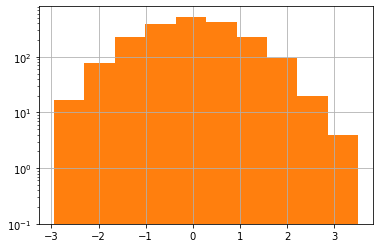

In [135]:
# source: https://stackoverflow.com/questions/21033720/python-pandas-histogram-log-scale
# plotting random normal distribution
series = pd.Series(np.random.normal(size=2000))
fig, ax = plt.subplots()
series.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')
series.hist()

In [156]:
s = pd.Series(np.random.randn(5), index=['a', 'b', 'c', 'd', 'e'])
print(s)

a    0.934529
b    0.627837
c   -0.025933
d   -0.691074
e    0.395620
dtype: float64
